In [1]:
%load_ext autoreload
%autoreload 2

# DiffyFuzz

`DiffyFuzz` is a novel testing tool that approximates program logic differentiably so that inputs can be crafted to access tricky branches.

This tool can be used directly or incorporated as an extension to other techniques, like symbolic and concolic execution. When the base tool can no longer improve coverage statistics, DiffyFuzz activates to expand coverage for numerically guarded branches.

## Installs and Imports

In [2]:
from legend import *

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, random_split

# from sklearn.preprocessing import MinMaxScaler

import torchvision
import torchmetrics

from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from target_programs.functions_to_approximate import *
from SymbolicFuzzer import SimpleSymbolicFuzzer

import ast
import astor
import time
import inspect
import itertools
from collections import deque
from tqdm.notebook import tqdm

import pyfuzz

from cleverhans.torch.utils import clip_eta
from cleverhans.torch.utils import optimize_linear

In [4]:
np.set_printoptions(precision=4)

## Subject Program

In [5]:
def dl_textbook_fn(x):
    return (0.2) + \
           (0.4 * x**2) + \
           (0.3 * np.sin(15 * x)) + \
           (0.05 * np.cos(50 * x))

In [6]:
def program_7(x: float):
    y:float = dl_textbook_fn(x)
    print(y)

    if y > 100:
        return "dl_textbook_fn returned a positive value!"
    elif y < 100:
        return "dl_textbook_fn returned a negative value!"

    if round(y, 0) == 100:
        raise Exception("You found a hard-to-reach bug!")

## Phase 1
Run a baseline test generation routine to initialize a coverage profile

### Code

In [7]:
# class SimpleSymbolicFuzzer(Fuzzer):
#     """Simple symbolic fuzzer"""
#     ...
#     Too much to display here!

### Phase Demo

In [8]:
phase1_start = time.time()

config = get_subject_programs_config()[6]

results = []

symbolic_execution = config['symbolic']
symbolic_target_program = config['symbolic_target_program']
target_program = config['target_program']
precision = config['precision']
external_func_length = config['external_func_length']

symfz_ct = SimpleSymbolicFuzzer(
    symbolic_target_program, 
    precision = precision, 
    external_func_length = external_func_length
)

#check if symbolic execution can be performed
if symbolic_execution:
    symfz_ct.start_execution(tries=100)
else:
    symfz_ct.collect_branch_conditions()

print("Branch Cov (%):", symfz_ct.calculate_branch_coverage())
print("Uncovered Branches:", symfz_ct.branches_uncovered)

results.append(target_program.__name__)
results.append(str(symfz_ct.calculate_branch_coverage())+'%')
results.append(str(symfz_ct.execution_time)+" sec")

if(len(symfz_ct.branches_uncovered) == 0):
    results.append('NA')
    
phase1_end = time.time()

Branch Cov (%): 0.0
Uncovered Branches: [[5, 0], [5, 1], [7, 0], [7, 1], [10, 0], [10, 1]]


## Phase 2

Identify blocking code logic that inhibits branch exploration


### Code

In [9]:
class FunctionAndBranchConditionsExtractor():
    """Extract function for dataset generation and condition components"""

    def __init__(self, sub_program):
        self.var_map = {}
        self.sub_program = sub_program

    def collectVariables(self, tree):
        """Explores the AST and stores function assignment in a dictionary"""
        def traverse(node):
            if isinstance(node, ast.AnnAssign):
                self.var_map[node.target.id] = node
            for child in ast.iter_child_nodes(node):
                traverse(child)
        traverse(tree)
        return self.var_map

    def extractVariables(self, tree):
        """Explores the AST and returns the function name used for variable assignment"""
        variables = []
        
        def traverse(node):
            if isinstance(node, ast.Name):
                if node.id in self.var_map:
                    variables.append(astor.to_source(self.var_map[node.id].value).strip())
            for child in ast.iter_child_nodes(node):
                traverse(child)
        traverse(tree)
        return variables[0]

    def collect_conditionComponents(self, tree):
        """Explores the AST and extracts branch conditions and target function"""
        conditionComponents = []
        self.collectVariables(tree)
        """Extract uncovered branches"""
        branches = [b for b, _ in self.sub_program.branches_uncovered]

        def traverse(node):
            if isinstance(node, ast.If):
                if node.lineno in branches:
                    conditionComponentsDict = {}
                    conditionComponentsDict["target_fn"] = self.extractVariables(node.test)
                    processed_branchConditions = self.process_branchConditions(astor.to_source(node.test).strip())
                    conditionComponentsDict["branch_conditions"] = [{}]
                    conditionComponentsDict["branch_conditions"][0]["operator"] = processed_branchConditions[0]
                    conditionComponentsDict["branch_conditions"][0]["target"] = processed_branchConditions[1]
                    conditionComponents.append(conditionComponentsDict)
            for child in ast.iter_child_nodes(node):
                traverse(child)
        traverse(tree)
        return conditionComponents

    def process_branchConditions(self, branchCondition):
        "Extract operand and target from branch conditions"
        branchCondition = branchCondition[1:-1]
        branchConditionArray = []
        branchConditionArray = branchCondition.split()
        branchConditionArrayUpdated = [branchConditionArray[len(branchConditionArray) - 2], branchConditionArray[len(branchConditionArray) - 1]]
        return branchConditionArrayUpdated

### Phase Demo

In [10]:
phase2_start = time.time()

source_ast = ast.parse(inspect.getsource(target_program))

funCondExtractor = FunctionAndBranchConditionsExtractor(symfz_ct)

"""Pass the function ast to extract branch conditions and target function"""
funCondExtractor.collect_conditionComponents(source_ast)

conditionComponents = funCondExtractor.collect_conditionComponents(source_ast)
# print(conditionComponents)
# sys.exit(0)

"Process the condition components to obtain the function in memory and extract operands and target from branch conditions"
processed_conditionComponentsArray = []
processed_conditionComponentsDict = {}
processed_conditionComponentsDict["branch_conditions"] = []

target = conditionComponents[0]["target_fn"]
targetNew = ""

for char in target:
    if char != "(":
        targetNew += char
    elif char == "(":
        break 
# print(locals())
processed_conditionComponentsDict["target_fn"] = eval(targetNew)

for idx in range(len(conditionComponents)):
    processed_conditionComponentsDict["branch_conditions"].append(conditionComponents[idx]["branch_conditions"][0])

processed_conditionComponentsArray.append(processed_conditionComponentsDict)

phase2_end = time.time()

In [11]:
processed_conditionComponentsArray

[{'branch_conditions': [{'operator': '>', 'target': '100'},
   {'operator': '<', 'target': '100'},
   {'operator': '==', 'target': '100'}],
  'target_fn': <function __main__.dl_textbook_fn(x)>}]

## Phase 3
Approximate target function with a differentiable function

### Code

#### Dataset Generator

In [12]:
class DatasetGenerator:
    def __init__(self, fn):
      
        self.fn = fn

        # extract fn argument details
        argspecs = inspect.getfullargspec(self.fn)
        self.args = argspecs.args
        self.defaults = argspecs.defaults

        self.num_inputs = len(self.args)
        self.num_outputs = inspect.getsource(self.fn).split().count("return")

    @staticmethod
    def fuzz_inputs(num_inputs = 1000, 
                    input_range = (-255, 255), 
                    seed = None):
        if not seed:
            seed = [bytearray(range(10))]
        fuzzer = pyfuzz.MutationFuzzer(seed, mutator=pyfuzz.mutate_bytes)
        input_bytes = [fuzzer.fuzz() for _ in range(num_inputs)]
        inputs = []
        for in_ in input_bytes:
            fdi = pyfuzz.FuzzedDataInterpreter(in_)
            inputs.append(fdi.claim_float_in_range(input_range[0], input_range[1]))
        return inputs

    def __call__(self, 
                 input_range = (-255, 255), 
                 num_examples_per_arg = 1000,
                 scaler = None,
                 train_test_split = 0.9,
                 batch_size = 10,
                 max_dataset_size = 10000,
                 fuzz_generate = True):
      
        inputs = {}
        for a in self.args:

            if fuzz_generate:
                inputs[a] = self.fuzz_inputs(num_inputs=num_examples_per_arg, 
                                            input_range=input_range)
            else:
                inputs[a] = np.linspace(start=input_range[0], 
                                        stop=input_range[1], 
                                        num=num_examples_per_arg)

        X = torch.Tensor(list(itertools.product(*inputs.values())))

        # enforce dataset size limit
        if len(X) > max_dataset_size:
            idx = torch.randperm(len(X))
            X = X[idx]
            X = X[:max_dataset_size]

        y = torch.Tensor([self.fn(*x) for x in X])

        # filter out inf
        X = X[~torch.isinf(y)]
        y = y[~torch.isinf(y)]

        # scale dataset if provided
        if scaler:
            self.x_scaler = scaler()
            self.y_scaler = scaler()

            self.x_scaler.fit(X)
            self.y_scaler.fit(y)

            X = self.x_scaler.transform(X)
            y = self.y_scaler.transform(y)
            
        if self.num_outputs == 1:
            y = y.float().reshape(-1, 1)
        else:
            y = torch.flatten(y.long())

        full_dataset = TensorDataset(X, y)

        # split dataset for train & test
        train_size = int(train_test_split * len(full_dataset))
        test_size = len(full_dataset) - train_size
        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

        # package as dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, test_loader

#### Model

In [13]:
class FuncApproximator(LightningModule):
    def __init__(self, input_size=1, output_size=1):
        self.input_size = input_size
        self.output_size = output_size
        super(FuncApproximator, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, output_size),
        )
        if output_size == 1:
            self.loss_fn = F.l1_loss # F.mse_loss F.l1_loss
        else:
            self.loss_fn = F.cross_entropy
            self.accuracy = torchmetrics.Accuracy()
            self.accuracy.mode = "multi-class"

        # set after training
        self.x_scaler = None
        self.y_scaler = None

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        return [optimizer], [lr_scheduler]

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        train_loss = self.loss_fn(out, y)

        # log step metric
        self.log("train_loss", train_loss)

        if self.output_size > 1:
            self.accuracy(out, y)
            self.log('train_acc', self.accuracy)

        return train_loss

    def training_epoch_end(self, outs):
        # log epoch metric
        if self.output_size > 1:
            self.log('train_acc_epoch', self.accuracy)

    # def validation_step(self, batch, batch_idx):
    #     x, y = batch
    #     out = self(x)
        
    #     # log step metric
    #     val_loss = self.loss_fn(out, y)
    #     self.log("val_loss", val_loss)
        
    #     if self.output_size > 1:
    #         self.accuracy(out, y)
    #         self.log('val_acc', self.accuracy)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        test_loss = self.loss_fn(out, y)
        
        # log step metric
        self.log("test_loss", test_loss)
        
        if self.output_size > 1:
            self.accuracy(out, y)
            self.log('test_acc', self.accuracy)


    def predict(self, x):
        if self.x_scaler:
            x = self.x_scaler.transform(x)
        y_pred = self(x)
        if self.y_scaler and self.output_size == 1:
            y_pred = self.y_scaler.inverse_transform(y_pred)
        return y_pred
        

class MinMaxScaler(object):
    """MinMax Scaler
    Transforms each channel to the range [a, b].
    Parameters
    ----------
    feature_range : tuple
        Desired range of transformed data.
    """

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        if not 'feature_range' in kwargs:
            self.feature_range = [0, 1]

    def fit(self, tensor):
        self.min_ = tensor.min(dim=0, keepdim=True)[0]
        self.max_ = tensor.max(dim=0, keepdim=True)[0]
        dist = self.max_ - self.min_
        dist[dist == 0.0] = 1.0
        self.scale_ = 1.0 / dist
        return self

    def transform(self, tensor):
        tensor = torch.clone(tensor)
        a, b = self.feature_range
        tensor = (tensor - self.min_) * self.scale_
        tensor = tensor * (b - a) + a
        return tensor

    def inverse_transform(self, tensor):
        tensor = torch.clone(tensor)
        tensor /= self.scale_
        tensor += self.min_
        return tensor

### Phase Demo

In [28]:
phase3_start = time.time()

fn = processed_conditionComponentsArray[0]['target_fn']

dg = DatasetGenerator(fn)

train_loader, test_loader = dg(
    scaler=MinMaxScaler, 
    num_examples_per_arg = 2000, 
    max_dataset_size = 2000, 
    batch_size=10, 
    fuzz_generate=False)

model = FuncApproximator(
    input_size=dg.num_inputs,
    output_size=dg.num_outputs)

tb_logger = pl_loggers.TensorBoardLogger("./logs/", name=fn.__name__)
escb = EarlyStopping(monitor="train_loss", min_delta=0.00, patience=2, verbose=False, mode="min")

trainer = Trainer(
    max_epochs=3,
    gpus=torch.cuda.device_count(),
    logger=tb_logger,
    callbacks=[escb]
)

trainer.fit(model, train_loader)
trainer.test(model, test_loader)

if 'x_scaler' in dg.__dict__:
    model.x_scaler = dg.x_scaler
if 'y_scaler' in dg.__dict__:
    model.y_scaler = dg.y_scaler

phase3_end = time.time()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name              | Type       | Params
-------------------------------------------------
0 | flatten           | Flatten    | 0     
1 | linear_relu_stack | Sequential | 264 K 
-------------------------------------------------
264 K     Trainable params
0         Non-trainable params
264 K     Total params
1.057     Total estimated model params size (MB)
C:\Users\fabriceyhc\anaconda3\envs\pyfuzz\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

C:\Users\fabriceyhc\anaconda3\envs\pyfuzz\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0011370346182957292}
--------------------------------------------------------------------------------


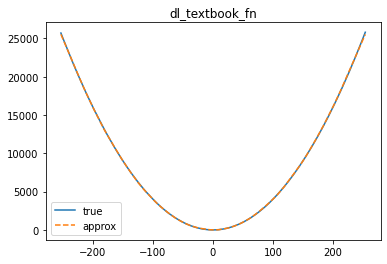

In [29]:
if model.output_size == 1:
    x, y_true = test_loader.dataset[:]
    x = model.x_scaler.inverse_transform(x)
    y_true = model.y_scaler.inverse_transform(y_true)
    y_pred = model.predict(x)

    sns.lineplot(x=x.view(-1), y=y_true.view(-1), label = 'true')
    sns.lineplot(x=x.view(-1), y=y_pred.view(-1).detach(), linestyle='--', label = 'approx')
    plt.title(fn.__name__)

    plt.show()

## Phase 4
Generate new tests via gradient-guided mutations

### Code

In [30]:
from input_generator import *

In [31]:
class GradientInputGenerator:
    def __init__(self, 
                 eps=1., 
                 eps_iter=0.1, 
                 nb_iter=1000, 
                 norm=2,
                 target_scaler=255,
                 num_seeds=1):
      
        self.eps = eps
        self.eps_iter = eps_iter
        self.nb_iter = nb_iter
        self.norm = norm
        self.target_scaler = target_scaler
        self.num_seeds = num_seeds

    def __call__(self, 
                 model,
                 op,
                 target,
                 seed=None):
      
        if not seed:
            # create default seed at midpoint in input space [0,1]
            seed = torch.rand((self.num_seeds, model.input_size))
        else:
            # scale provided input seed for model
            seed = model.x_scaler.transform(seed)

        # set target op for pgd
        if op == ">" or op == ">=":
            # make larger
            target = 1. if target == 0 else target
            target = target * self.target_scaler
        elif op == "<" or op == "<=":
            # make smaller
            target = 1. if target == 0 else target
            target = target * -self.target_scaler
        elif op == "==":
            # equal the target value
            target = target
        else:
            raise ValueError("Unhandled op!")

        target = torch.full((self.num_seeds, 1), target) 

        # loss function + target transform based on model output 
        if model.output_size == 1:
            loss_fn = F.l1_loss  
            if op != "==":
                target *= torch.rand_like(target)
            target  = model.y_scaler.transform(target)
        else:
            loss_fn = F.cross_entropy
            target  = target.reshape(-1).long()
 
        # generate input via pgd
        x_adv = projected_gradient_descent(
            model_fn=model,
            x=seed,
            y=target,
            targeted=True,
            loss_fn=loss_fn,
            eps=self.eps,
            eps_iter=self.eps_iter, 
            nb_iter=self.nb_iter,
            norm=self.norm,
            clip_min=0,
            clip_max=1,
            rand_init=True,
            rand_minmax=None,
            sanity_checks=False,
            early_stopping=True
        ).detach()

        x_adv = model.x_scaler.inverse_transform(x_adv)

        return x_adv

### Phase Demo

In [33]:
phase4_start = time.time()

op_targets = []
for cond in processed_conditionComponentsArray[0]['branch_conditions']:
    op_targets.append((cond['operator'], float(cond['target'])))

generator = GradientInputGenerator(num_seeds=5)

for op, target in op_targets:
    x_adv = generator(model=model, op=op, target=target).numpy()
    
    print("op:", op, 'target:', target)
    print('x_adv:', x_adv.reshape(-1))
    symfz_ct.collect_additional_covergae(x_adv, model.input_size)
    
phase4_end = time.time()

op: > target: 100.0
x_adv: [-128.761  -161.6738 -132.4278 -110.3967   94.7062]
6631.738230623121
10455.580507299925
7014.831078929342
4875.221403183651
3588.046596067835
op: < target: 100.0
x_adv: [2.9609 2.9609 2.9609 2.9596 2.9609]
3.7859697133827868
3.7857436732443444
3.786195835636982
3.7761029207355326
3.7859697133827868
op: == target: 100.0
x_adv: [-12.4349  15.7057  15.7055 -12.4348 -12.4348]
62.374847593641114
98.92737171534905
98.92609600469517
62.37389948398982
62.37389948398982


In [34]:
print("Branch Cov (%):", symfz_ct.calculate_branch_coverage())

total_time = phase1_end - phase1_start + \
             phase2_end - phase2_start + \
             phase3_end - phase3_start + \
             phase4_end - phase4_start

print("Total Runtime:", total_time)

Branch Cov (%): 50.0
Total Runtime: 6.834798574447632
